In [113]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_theme(style="whitegrid")
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
sns.set_theme(style="whitegrid")
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine, euclidean
from sklearn.preprocessing import StandardScaler


In [114]:
#Load all datasets
# Main Dataset

# Conversation Data -- we will use this data in the "Conversation Data" section
df = pd.read_json(
    "../data/training-set/chatbot-arena-conversations.jsonl.gz",
    lines=True,
    compression="gzip"
)
df.head(5)
# Auxiliary Datasets

# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "../data/training-set/chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "../data/training-set/chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "../data/training-set/chatbot-arena-model_b_response-embeddings.npy"
)

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "../data/training-set/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [115]:
#split prompt and response, add columns with lengths (characters)
df["prompt"] = df["conversation_a"].str[0].str["content"]
df["response_a"] = df["conversation_a"].str[1].str["content"]
df["response_b"] = df["conversation_b"].str[1].str["content"]

In [116]:
#prompt and response tokenization
import re

# \b\w+\b captures words by looking for word boundaries (\b) and word characters (\w+)
pattern = r"\b\w+\b"

# Apply regex tokenization to each column in your dataframe
df['prompt_tokens'] = df['prompt'].apply(lambda x: re.findall(pattern, x))
df['a_response_tokens'] = df['response_a'].apply(lambda x: re.findall(pattern, x))
df['b_response_tokens'] = df['response_b'].apply(lambda x: re.findall(pattern, x))

# Calculate token counts
df['prompt_token_length'] = df['prompt_tokens'].apply(len)
df['a_response_token_length'] = df['a_response_tokens'].apply(len)
df['b_response_token_length'] = df['b_response_tokens'].apply(len)

In [117]:
import textstat

# Define functions for each readability score
def flesch_kincaid_score(text):
    return textstat.flesch_kincaid_grade(text)

def gunning_fog_score(text):
    return textstat.gunning_fog(text)

def smog_score(text):
    return textstat.smog_index(text)


In [118]:
# Calculate readability scores for each response
df['a_response_flesch_kincaid'] = df['response_a'].apply(flesch_kincaid_score)
df['a_response_gunning_fog'] = df['response_a'].apply(gunning_fog_score)
df['a_response_smog'] = df['response_a'].apply(smog_score)

df['b_response_flesch_kincaid'] = df['response_b'].apply(flesch_kincaid_score)
df['b_response_gunning_fog'] = df['response_b'].apply(gunning_fog_score)
df['b_response_smog'] = df['response_b'].apply(smog_score)


In [119]:
import textstat
from lexical_diversity import lex_div as ld
from collections import Counter

# Lexical Richness: Type-Token Ratio (unique words / total words)
def type_token_ratio(text):
    tokens = text.split()
    unique_tokens = set(tokens)
    return len(unique_tokens) / len(tokens) if tokens else 0

# Lexical Richness: Lexical Diversity
def lexical_diversity(text):
    tokens = text.split()
    return ld.ttr(tokens)  # Alternatively, you can use other functions in lex_div

# Average Syllable Count per Word
def average_syllable_count(text):
    tokens = text.split()
    if len(tokens) == 0:
        return 0
    total_syllables = sum(textstat.syllable_count(word) for word in tokens)
    return total_syllables / len(tokens)

# Complex Word Count (words with more than three syllables)
def complex_word_count(text):
    tokens = text.split()
    return sum(1 for word in tokens if textstat.syllable_count(word) > 3)


In [120]:
# Lexical richness, syllable count, and complex word count for each response
df['a_response_ttr'] = df['response_a'].apply(type_token_ratio)
df['a_response_lexical_diversity'] = df['response_a'].apply(lexical_diversity)
df['a_response_avg_syllable_count'] = df['response_a'].apply(average_syllable_count)
df['a_response_complex_word_count'] = df['response_a'].apply(complex_word_count)

df['b_response_ttr'] = df['response_b'].apply(type_token_ratio)
df['b_response_lexical_diversity'] = df['response_b'].apply(lexical_diversity)
df['b_response_avg_syllable_count'] = df['response_b'].apply(average_syllable_count)
df['b_response_complex_word_count'] = df['response_b'].apply(complex_word_count)


In [121]:
def jaccard_similarity(tokens_a, tokens_b):
    set_a = set(tokens_a)
    set_b = set(tokens_b)
    intersection = set_a.intersection(set_b)
    union = set_a.union(set_b)
    return len(intersection) / len(union) if union else 0


In [122]:
# Calculate Jaccard similarity between tokens of response_a and response_b
df['response_jaccard_similarity'] = df.apply(
    lambda row: jaccard_similarity(row['a_response_tokens'], row['b_response_tokens']), axis=1
)

# Calculate Jaccard similarity between the prompt and each response
df['prompt_a_jaccard_similarity'] = df.apply(
    lambda row: jaccard_similarity(row['prompt_tokens'], row['a_response_tokens']), axis=1
)

df['prompt_b_jaccard_similarity'] = df.apply(
    lambda row: jaccard_similarity(row['prompt_tokens'], row['b_response_tokens']), axis=1
)

In [123]:
# Check if the prompt contains a question mark and set binary value
df['is_question'] = df['prompt'].apply(lambda x: 1 if '?' in x else 0)

In [124]:
def keyword_overlap_count(prompt_tokens, response_tokens):
    # Convert tokens to sets and find the intersection
    overlap = set(prompt_tokens).intersection(set(response_tokens))
    return len(overlap)


In [125]:
# Calculate keyword overlap count for each response with the prompt
df['prompt_a_keyword_overlap'] = df.apply(lambda row: keyword_overlap_count(row['prompt_tokens'], row['a_response_tokens']), axis=1)
df['prompt_b_keyword_overlap'] = df.apply(lambda row: keyword_overlap_count(row['prompt_tokens'], row['b_response_tokens']), axis=1)
# Calculate keyword overlap count between the two responses
df['response_ab_keyword_overlap'] = df.apply(lambda row: keyword_overlap_count(row['a_response_tokens'], row['b_response_tokens']), axis=1)


In [126]:
def unique_word_count(tokens):
    return len(set(tokens))


In [127]:
# Calculate the number of unique words in the prompt and both responses
df['prompt_unique_words'] = df['prompt_tokens'].apply(unique_word_count)
df['a_response_unique_words'] = df['a_response_tokens'].apply(unique_word_count)
df['b_response_unique_words'] = df['b_response_tokens'].apply(unique_word_count)

In [128]:
politeness_indicators = ["please", "thank you", "could you", "kindly", "would you mind"]
negative_words = ["no", "not", "never", "can't", "won't", "don't", "hate", "bad"]
def contains_politeness(tokens):
    return 1 if any(word in tokens for word in politeness_indicators) else 0

def contains_negative(tokens):
    return 1 if any(word in tokens for word in negative_words) else 0


In [129]:
# Apply politeness and negativity indicators
df['prompt_contains_politeness'] = df['prompt_tokens'].apply(contains_politeness)
df['a_response_contains_politeness'] = df['a_response_tokens'].apply(contains_politeness)
df['b_response_contains_politeness'] = df['b_response_tokens'].apply(contains_politeness)

df['prompt_contains_negative'] = df['prompt_tokens'].apply(contains_negative)
df['a_response_contains_negative'] = df['a_response_tokens'].apply(contains_negative)
df['b_response_contains_negative'] = df['b_response_tokens'].apply(contains_negative)


In [130]:
text_features = df

In [131]:

# Function to calculate Cosine Similarity
def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors."""
    return 1 - cosine(vec1, vec2)

# Function to calculate Euclidean Distance
def euclidean_distance(vec1, vec2):
    """Calculate Euclidean distance between two vectors."""
    return euclidean(vec1, vec2)

# Function to calculate Embedding Difference
def embedding_difference(vec1, vec2):
    """Calculate the difference between two embeddings."""
    return vec1 - vec2

# Initialize lists to store features
cosine_sim_prompt_response_a = []
cosine_sim_prompt_response_b = []
cosine_sim_response_a_b = []
euclidean_dist_prompt_response_a = []
euclidean_dist_prompt_response_b = []
embedding_diff_a_b = []

# Iterate through the embeddings
for i in range(len(prompt_embeddings)):
    prompt = prompt_embeddings[i]
    response_a = response_a_embeddings[i]
    response_b = response_b_embeddings[i]
    
    # Cosine Similarity
    cosine_sim_prompt_response_a.append(cosine_similarity(prompt, response_a))
    cosine_sim_prompt_response_b.append(cosine_similarity(prompt, response_b))
    cosine_sim_response_a_b.append(cosine_similarity(response_a, response_b))
    
    # Euclidean Distance
    euclidean_dist_prompt_response_a.append(euclidean_distance(prompt, response_a))
    euclidean_dist_prompt_response_b.append(euclidean_distance(prompt, response_b))
    
    # Embedding Difference (can be logged or used for advanced features if needed)
    embedding_diff_a_b.append(embedding_difference(response_a, response_b))

# Create a DataFrame for embedding-based features
embeddings_features = pd.DataFrame({
    "cosine_sim_prompt_response_a": cosine_sim_prompt_response_a,
    "cosine_sim_prompt_response_b": cosine_sim_prompt_response_b,
    "cosine_sim_response_a_b": cosine_sim_response_a_b,
    "euclidean_dist_prompt_response_a": euclidean_dist_prompt_response_a,
    "euclidean_dist_prompt_response_b": euclidean_dist_prompt_response_b,
})


In [132]:
# Function to calculate embedding differences
def calculate_embedding_difference(vec1, vec2):
    """Calculate element-wise difference between two embeddings."""
    return vec1 - vec2

# Initialize lists to store the embedding differences
prompt_response_a_diff = []
prompt_response_b_diff = []

# Iterate through the embeddings
for i in range(len(prompt_embeddings)):
    prompt = prompt_embeddings[i]
    response_a = response_a_embeddings[i]
    response_b = response_b_embeddings[i]
    
    # Calculate element-wise differences for prompt and responses
    prompt_response_a_diff.append(calculate_embedding_difference(prompt, response_a))
    prompt_response_b_diff.append(calculate_embedding_difference(prompt, response_b))

# Add embedding differences as columns to the existing embeddings_features DataFrame
embeddings_features["prompt_response_a_diff"] = prompt_response_a_diff
embeddings_features["prompt_response_b_diff"] = prompt_response_b_diff


In [133]:
# Function to calculate variance of an embedding
def calculate_embedding_variance(embedding):
    """Calculate the variance of the embedding vector."""
    return np.var(embedding)

# Initialize lists to store variances for each embedding
variance_prompt = []
variance_response_a = []
variance_response_b = []

# Iterate through the embeddings to compute variances
for i in range(len(prompt_embeddings)):
    variance_prompt.append(calculate_embedding_variance(prompt_embeddings[i]))
    variance_response_a.append(calculate_embedding_variance(response_a_embeddings[i]))
    variance_response_b.append(calculate_embedding_variance(response_b_embeddings[i]))

# Append variances as new columns to the embeddings_features DataFrame
embeddings_features["variance_prompt"] = variance_prompt
embeddings_features["variance_response_a"] = variance_response_a
embeddings_features["variance_response_b"] = variance_response_b

# Display the updated DataFrame

In [134]:
# Function to extract a single digit using regex
def extract_digit(value):
    match = re.search(r"\d", str(value))  # Search for the first digit
    return int(match.group()) if match else None  # Return digit or None

# Apply the regex extraction to all relevant columns
for col in ["score_value_1", "score_value_2", "score_value_3"]:
    topic_and_hardness[col] = topic_and_hardness[col].apply(extract_digit)

# Calculate the combined hardness score (ignoring NaNs)
topic_and_hardness["combined_hardness_score"] = (
    topic_and_hardness[["score_value_1", "score_value_2", "score_value_3"]]
    .mean(axis=1, skipna=True)  # Calculate mean while ignoring NaN values
)

In [135]:
embeddings_features["question_id"] = text_features["question_id"]
embeddings_features["combined_hardness_score"] = topic_and_hardness["combined_hardness_score"]

In [136]:
text_features = text_features.drop_duplicates(subset="question_id")
embeddings_features = embeddings_features.drop_duplicates(subset="question_id")

In [137]:
all_features = text_features.merge(embeddings_features, on = "question_id")

In [138]:

# Select all columns with numerical data types (int or float)
X = all_features.select_dtypes(include=['int64', 'float64', 'float32'])


# X = X.drop(columns=['combined_hardness_score'])

# Set the target column
y = all_features['combined_hardness_score']

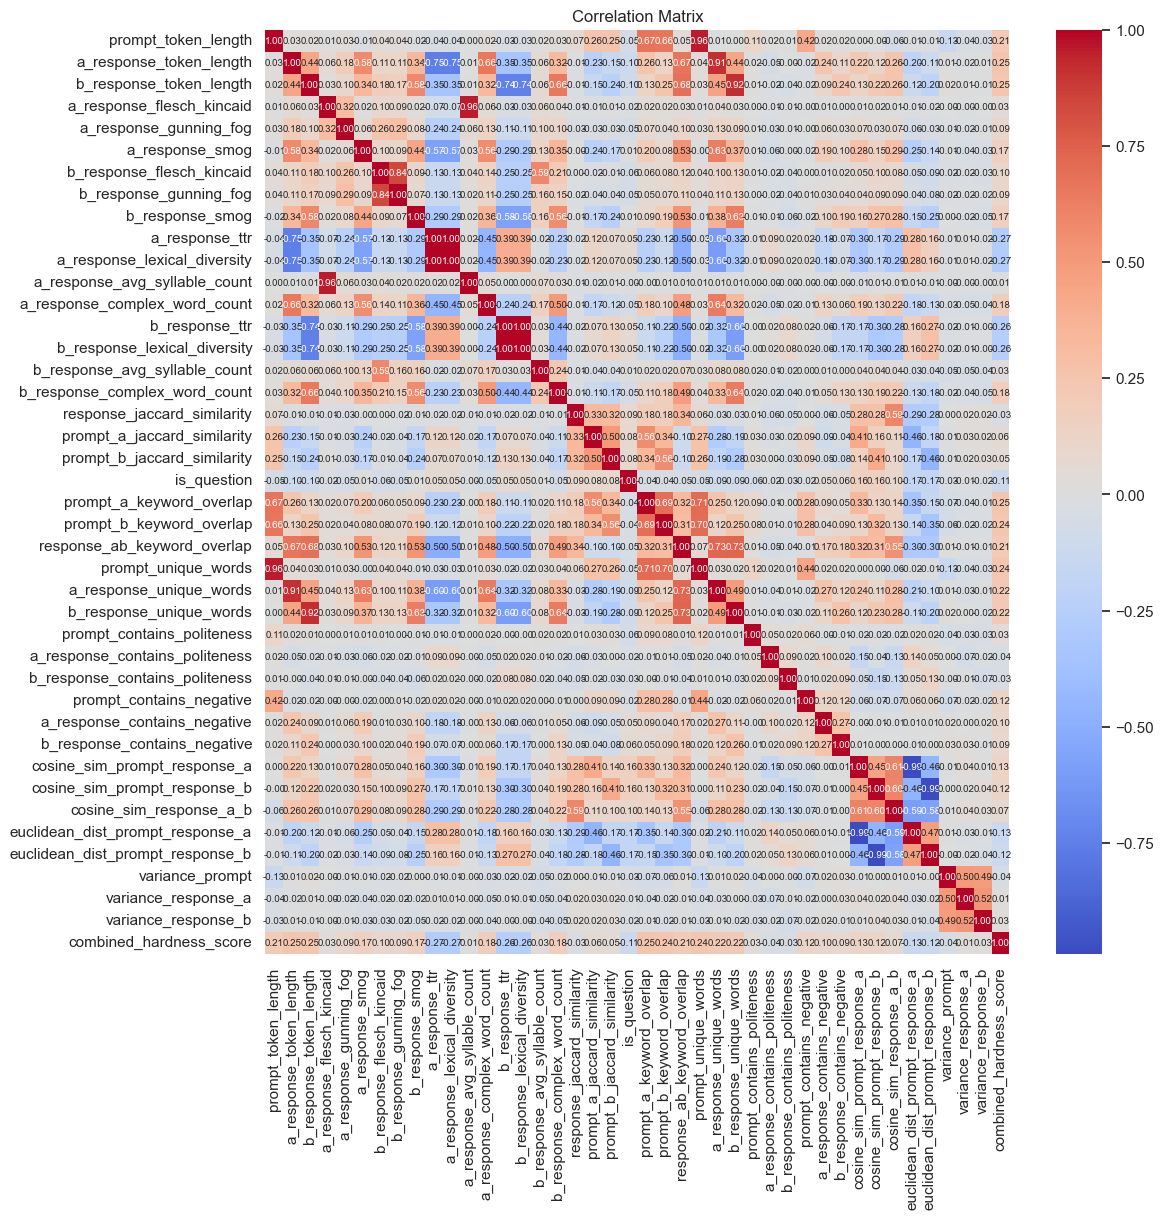


Correlations with Combined Hardness Score:
 combined_hardness_score             1.000000
prompt_a_keyword_overlap            0.247863
a_response_token_length             0.246933
b_response_token_length             0.245779
prompt_unique_words                 0.242509
prompt_b_keyword_overlap            0.240132
b_response_unique_words             0.216338
a_response_unique_words             0.215919
response_ab_keyword_overlap         0.214776
prompt_token_length                 0.208138
a_response_complex_word_count       0.180528
b_response_complex_word_count       0.175707
b_response_smog                     0.167424
a_response_smog                     0.165743
cosine_sim_prompt_response_a        0.127432
prompt_contains_negative            0.122375
cosine_sim_prompt_response_b        0.115338
b_response_flesch_kincaid           0.098013
a_response_contains_negative        0.095605
a_response_gunning_fog              0.092944
b_response_gunning_fog              0.091895
b_response

In [139]:
# Create a dataframe with only numerical columns
numerical_features = X

# Compute the correlation matrix
correlation_matrix = numerical_features.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, annot_kws={"size": 7})
plt.title('Correlation Matrix')
plt.show()

# Look specifically at correlations with the target variable
target_corr = correlation_matrix['combined_hardness_score'].sort_values(ascending=False)
print("\nCorrelations with Combined Hardness Score:\n", target_corr)

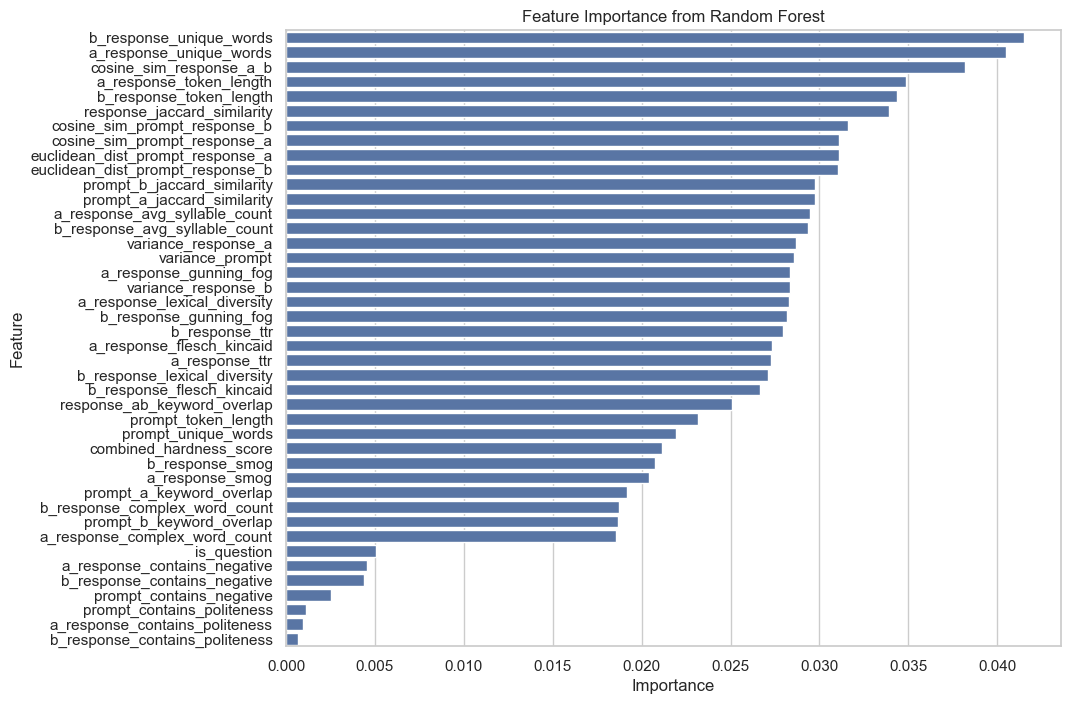

In [140]:
from sklearn.ensemble import RandomForestClassifier
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(all_features['winner'])

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)


feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [141]:
#Load all datasets
# Main Dataset

# Conversation Data -- we will use this data in the "Conversation Data" section
df = pd.read_json(
    "../data/training-set/chatbot-arena-conversations.jsonl.gz",
    lines=True,
    compression="gzip"
)
df.head(5)
# Auxiliary Datasets

# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "../data/training-set/chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "../data/training-set/chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "../data/training-set/chatbot-arena-model_b_response-embeddings.npy"
)

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "../data/training-set/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [142]:
no_ties = df[(df['winner'] != 'tie') & (df['winner'] != 'tie (bothbad)')]

In [143]:
cnt = 0
wins = 0
for index, row in no_ties.iterrows():
    if (row['model_a'] == 'gpt-4' and row['model_b'] == 'llama-13b') or (row['model_a'] == 'llama-13b' and row['model_b'] == 'gpt-4'):
        cnt += 1
        if (row['model_a'] == 'gpt-4' and row['winner'] == 'model_a') or (row['model_b'] == 'gpt-4' and row['winner'] == 'model_b'):
            wins += 1
    
print(cnt)
print(wins/cnt)

69
0.9710144927536232


In [144]:
battle_counts = pd.pivot_table(no_ties, index='model_a', columns='model_b', values='winner', aggfunc='count', fill_value=0, margins=True)
battle_counts = battle_counts + battle_counts.T
ordered_battle_counts = battle_counts.sort_values(by='All', ascending=False).drop('All', axis=1).sort_values(by='All', axis=1, ascending=False).drop('All', axis=0)
# ordered_battle_counts = battle_counts.sort_values(by='', key=lambda x: x.sum(), axis=0, ascending=False)
ordered_battle_counts

model_b,vicuna-13b,koala-13b,gpt-3.5-turbo,oasst-pythia-12b,gpt-4,alpaca-13b,claude-v1,RWKV-4-Raven-14B,chatglm-6b,fastchat-t5-3b,palm-2,stablelm-tuned-alpha-7b,claude-instant-v1,mpt-7b-chat,dolly-v2-12b,vicuna-7b,llama-13b,wizardlm-13b,guanaco-33b,gpt4all-13b-snoozy
model_a,,,,,,,,,,,,,,,,,,,,
vicuna-13b,0,411,210,328,207,236,179,171,203,132,110,182,108,119,197,96,172,35,33,39
koala-13b,411,0,246,242,214,222,194,139,151,137,131,151,97,115,164,91,124,28,22,26
gpt-3.5-turbo,210,246,0,218,172,207,185,202,147,174,128,114,90,122,135,122,92,46,41,43
oasst-pythia-12b,328,242,218,0,233,174,201,116,157,109,105,129,96,98,126,69,100,49,43,31
gpt-4,207,214,172,233,0,182,165,201,162,152,116,141,87,147,113,121,69,33,42,41
alpaca-13b,236,222,207,174,182,0,201,121,159,115,88,126,84,72,121,73,100,24,19,22
claude-v1,179,194,185,201,165,201,0,196,133,127,113,85,69,127,87,116,60,37,20,47
RWKV-4-Raven-14B,171,139,202,116,201,121,196,0,78,79,107,66,92,87,51,83,40,40,40,20
chatglm-6b,203,151,147,157,162,159,133,78,0,73,76,75,77,57,88,49,62,10,21,18


<Axes: xlabel='model_b', ylabel='model_a'>

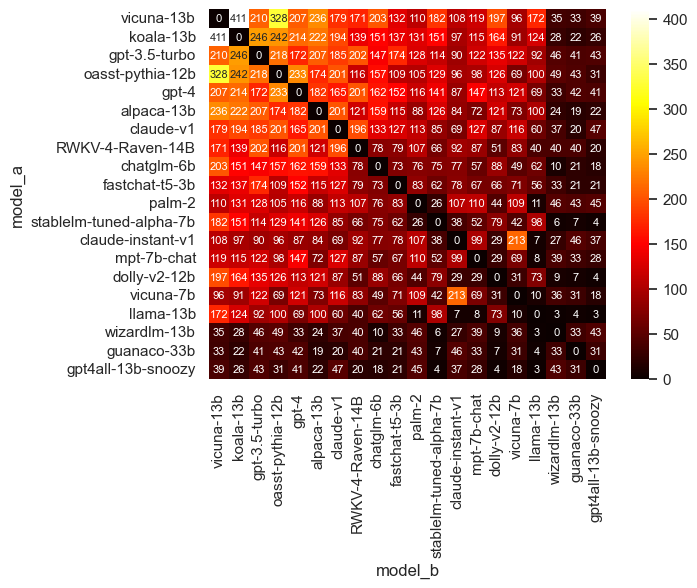

In [145]:
sns.heatmap(ordered_battle_counts, annot=True, fmt='d', cmap='hot', annot_kws={"size": 8})

In [146]:
win_rates = (pd.pivot_table(no_ties[no_ties['winner'] == 'model_a'], index='model_a', columns='model_b', values='winner', aggfunc='count', fill_value=0, margins=True) + pd.pivot_table(no_ties[no_ties['winner'] == 'model_b'], index='model_a', columns='model_b', values='winner', aggfunc='count', fill_value=0, margins=True).T) / battle_counts
win_rates = win_rates.fillna(0)
win_rates = win_rates.sort_values(by='All', ascending=False).drop('All', axis=1).sort_values(by='All', axis=1, ascending=False).drop('All', axis=0)
win_rates

model_b,llama-13b,dolly-v2-12b,stablelm-tuned-alpha-7b,fastchat-t5-3b,chatglm-6b,RWKV-4-Raven-14B,gpt4all-13b-snoozy,oasst-pythia-12b,alpaca-13b,mpt-7b-chat,vicuna-7b,koala-13b,wizardlm-13b,palm-2,guanaco-33b,vicuna-13b,gpt-3.5-turbo,claude-instant-v1,claude-v1,gpt-4
model_a,,,,,,,,,,,,,,,,,,,,
gpt-4,0.971014,0.955752,0.929078,0.914474,0.907407,0.890547,0.853659,0.909871,0.956044,0.918367,0.801653,0.859813,0.818182,0.775862,0.642857,0.879227,0.779070,0.689655,0.545455,0.000000
claude-v1,0.983333,0.942529,0.894118,0.960630,0.879699,0.862245,0.914894,0.885572,0.910448,0.874016,0.767241,0.783505,0.783784,0.725664,0.650000,0.793296,0.583784,0.507246,0.000000,0.454545
claude-instant-v1,0.571429,0.862069,0.973684,0.884615,0.909091,0.869565,0.702703,0.822917,0.821429,0.848485,0.812207,0.835052,0.740741,0.747664,0.782609,0.712963,0.566667,0.000000,0.492754,0.310345
gpt-3.5-turbo,0.945652,0.911111,0.912281,0.862069,0.897959,0.787129,0.674419,0.839450,0.884058,0.778689,0.737705,0.735772,0.695652,0.585938,0.439024,0.604762,0.000000,0.433333,0.416216,0.220930
vicuna-13b,0.877907,0.857868,0.824176,0.795455,0.837438,0.736842,0.717949,0.750000,0.788136,0.680672,0.541667,0.618005,0.542857,0.418182,0.454545,0.000000,0.395238,0.287037,0.206704,0.120773
guanaco-33b,0.750000,0.714286,0.857143,0.857143,0.714286,0.700000,0.838710,0.790698,0.684211,0.787879,0.612903,0.500000,0.636364,0.558140,0.000000,0.545455,0.560976,0.217391,0.350000,0.357143
palm-2,0.909091,0.909091,0.923077,0.783133,0.815789,0.813084,0.688889,0.771429,0.761364,0.700000,0.660550,0.687023,0.434783,0.000000,0.441860,0.581818,0.414062,0.252336,0.274336,0.224138
wizardlm-13b,0.666667,1.000000,0.833333,0.757576,0.600000,0.650000,0.604651,0.857143,0.750000,0.666667,0.638889,0.500000,0.000000,0.565217,0.363636,0.457143,0.304348,0.259259,0.216216,0.181818
koala-13b,0.846774,0.798780,0.794702,0.759124,0.741722,0.575540,0.846154,0.702479,0.684685,0.669565,0.417582,0.000000,0.500000,0.312977,0.500000,0.381995,0.264228,0.164948,0.216495,0.140187


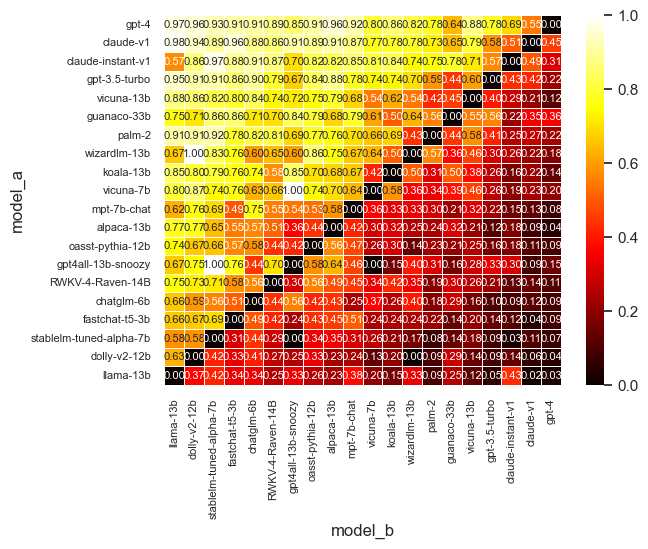

In [147]:
ax = sns.heatmap(win_rates, annot=True, fmt='.2f', cmap='hot', annot_kws={"size": 8}, linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
models = pd.concat([df['model_a'], df['model_b']]).unique()
merge_df = pd.merge(df, topic_and_hardness, on='question_id')

In [148]:
def extract_digit(value):
    match = re.search(r"\d", str(value))  # Search for the first digit
    return int(match.group()) if match else None  # Return digit or None

# Apply the regex extraction to all relevant columns
for col in ["score_value_1", "score_value_2", "score_value_3"]:
    merge_df[col] = merge_df[col].apply(extract_digit)

merge_df["combined_hardness_score"] = (
    merge_df[["score_value_1", "score_value_2", "score_value_3"]]
    .mean(axis=1, skipna=True)  # Calculate mean while ignoring NaN values
)

In [149]:
appearances_a = merge_df[['model_a', 'combined_hardness_score']].rename(columns={'model_a': 'model'})
appearances_b = merge_df[['model_b', 'combined_hardness_score']].rename(columns={'model_b': 'model'})
appearances = pd.concat([appearances_a, appearances_b])
appearances_grouped = appearances.groupby(['model', 'combined_hardness_score']).agg('size').reset_index(name='appearances')


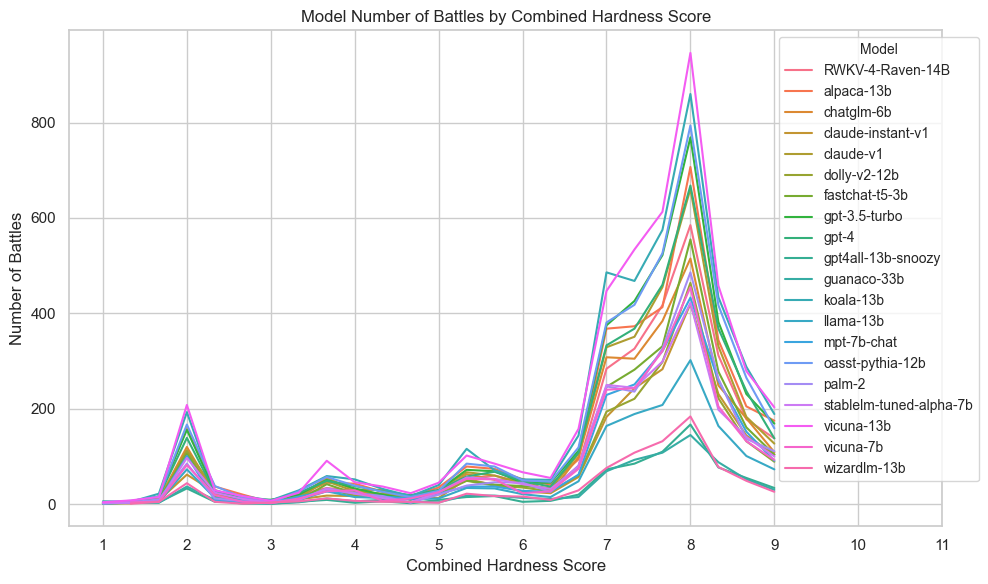

In [150]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=appearances_grouped, x='combined_hardness_score', y='appearances', hue='model', ax=ax)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper right', fontsize='small', title_fontsize='small')
plt.xticks(np.arange(1, 12, 1))
plt.title('Model Number of Battles by Combined Hardness Score')
plt.xlabel('Combined Hardness Score')
plt.ylabel('Number of Battles')
plt.tight_layout()

Text(0.5, 0.01, 'Combined Hardness Score')

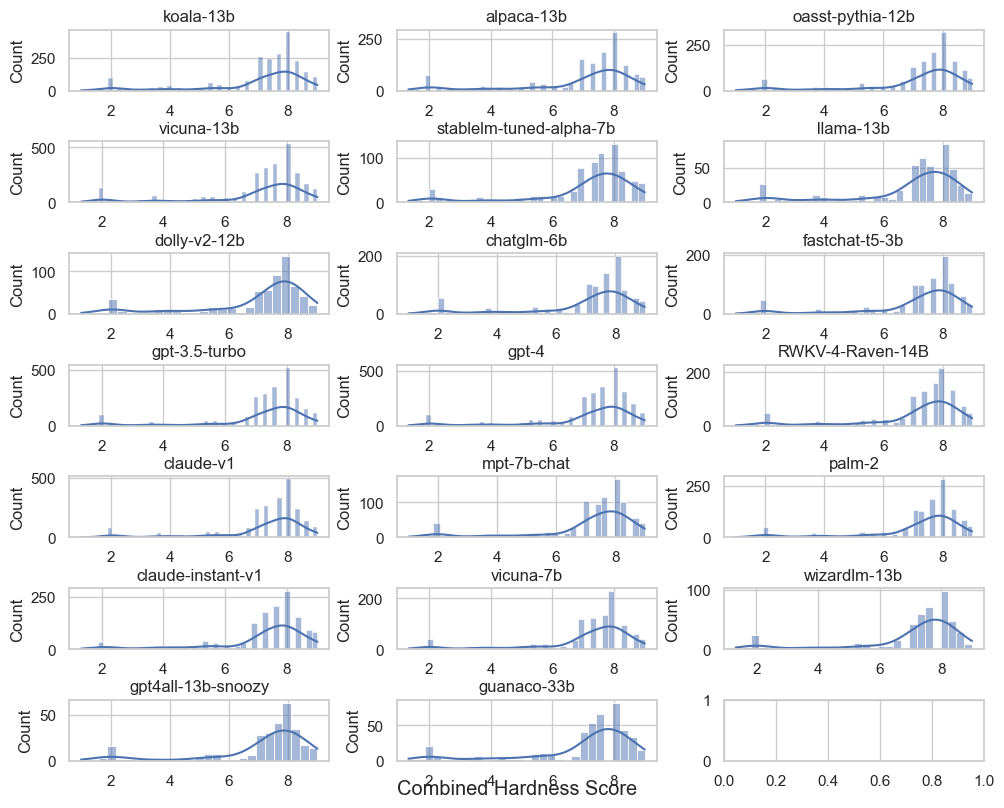

In [151]:
# figure out distribution of different users score models
merge_df['winning_model'] = merge_df.apply(lambda x: x['model_a'] if x['winner'] == 'model_a' else x['model_b'], axis=1)
winning_models = merge_df['winning_model'].unique()
model_combined_score = merge_df.groupby('winning_model')[['combined_hardness_score']].apply(lambda x: x).reset_index(level=1)

fig, axes = plt.subplots(7, 3, figsize=(10, 8))
fig.tight_layout()


for i in range(len(winning_models)):
    curr_model = winning_models[i]
    # plt.figure(i, figsize=(4, 3))
    sns.histplot(model_combined_score.loc[curr_model]['combined_hardness_score'], kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(curr_model)
    axes[i//3, i%3].set_xlabel('')
    # break
fig.supxlabel('Combined Hardness Score')

In [152]:

# Identify users with missing values
users_with_missing_values = merge_df[merge_df.isnull().any(axis=1)]['winning_model'].unique()

# Identify users with outliers in combined_hardness_score
outlier_threshold = merge_df['combined_hardness_score'].mean() + 3 * merge_df['combined_hardness_score'].std()
users_with_outliers = merge_df[merge_df['combined_hardness_score'] > outlier_threshold]['winning_model'].unique()
merge_df.groupby("judge")["winning_model"].value_counts(normalize=True)

judge             winning_model   
arena_user_1000   vicuna-13b          0.555556
                  alpaca-13b          0.222222
                  dolly-v2-12b        0.111111
                  koala-13b           0.111111
arena_user_10002  RWKV-4-Raven-14B    0.500000
                                        ...   
arena_user_9995   gpt-3.5-turbo       0.250000
                  gpt-4               0.250000
                  mpt-7b-chat         0.250000
arena_user_9997   gpt-3.5-turbo       1.000000
arena_user_9999   claude-v1           1.000000
Name: proportion, Length: 18642, dtype: float64

In [153]:
merge_df.groupby("judge").agg('size').describe()

count    10531.000000
mean         2.402621
std          7.215953
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        307.000000
dtype: float64

In [154]:
merge_df.groupby("judge").agg('size').sort_values(ascending=False).head(10)

judge
arena_user_9965     307
arena_user_257      288
arena_user_13046    192
arena_user_3820     181
arena_user_15085    178
arena_user_11473    158
arena_user_6467     119
arena_user_6585     103
arena_user_1338     100
arena_user_13514     78
dtype: int64

Text(0.5, 1.0, 'Cumulative Number of Battles per Judge')

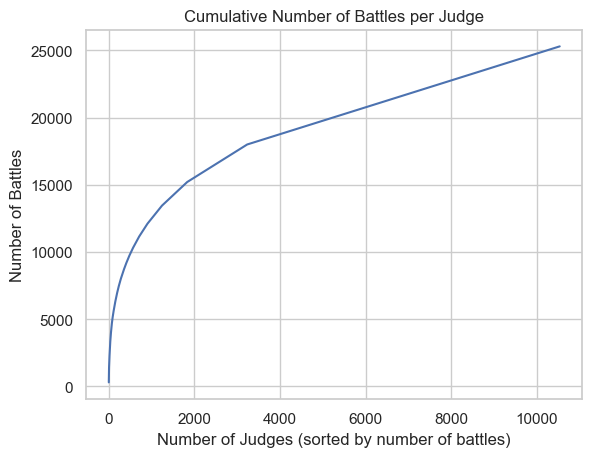

In [155]:
judge_cumulation = np.cumsum(merge_df.groupby("judge").agg('size').sort_values(ascending=False).values)
plt.plot(judge_cumulation)
plt.xlabel("Number of Judges (sorted by number of battles)")
plt.ylabel("Number of Battles")
plt.title("Cumulative Number of Battles per Judge")

In [156]:
merge_df['round_combined_hardness_score'] = merge_df['combined_hardness_score'].round()

In [157]:
merge_df.groupby('round_combined_hardness_score')[['winning_model']].value_counts(normalize=True)

round_combined_hardness_score  winning_model     
1.0                            oasst-pythia-12b      0.140625
                               claude-v1             0.078125
                               koala-13b             0.078125
                               mpt-7b-chat           0.078125
                               alpaca-13b            0.062500
                                                       ...   
9.0                            dolly-v2-12b          0.022286
                               guanaco-33b           0.017254
                               llama-13b             0.013659
                               wizardlm-13b          0.013659
                               gpt4all-13b-snoozy    0.011143
Name: proportion, Length: 180, dtype: float64

In [158]:
# get win percentage for each particular model
win_fracs = merge_df.groupby('winning_model').agg('size') / (merge_df.groupby('model_a').agg('size') + merge_df.groupby('model_b').agg('size'))

In [159]:
win_fracs_df = pd.DataFrame(win_fracs, columns = ['win_frac']).reset_index()
win_fracs_df

,winning_model,win_frac
0,RWKV-4-Raven-14B,0.394446
1,alpaca-13b,0.408291
2,chatglm-6b,0.356425
3,claude-instant-v1,0.686041
4,claude-v1,0.721482
5,dolly-v2-12b,0.298329
6,fastchat-t5-3b,0.370355
7,gpt-3.5-turbo,0.661398
8,gpt-4,0.779063
9,gpt4all-13b-snoozy,0.379310


In [160]:
appearances_a = merge_df[['model_a', 'round_combined_hardness_score']].rename(columns={'model_a': 'model'})
appearances_b = merge_df[['model_b', 'round_combined_hardness_score']].rename(columns={'model_b': 'model'})
appearances = pd.concat([appearances_a, appearances_b])
appearances_grouped = appearances.groupby(['model', 'round_combined_hardness_score']).agg('size').reset_index(name='appearances')
appearances_grouped

,model,round_combined_hardness_score,appearances
0,RWKV-4-Raven-14B,1.0,6
1,RWKV-4-Raven-14B,2.0,143
2,RWKV-4-Raven-14B,3.0,34
3,RWKV-4-Raven-14B,4.0,78
4,RWKV-4-Raven-14B,5.0,89
...,...,...,...
175,wizardlm-13b,5.0,30
176,wizardlm-13b,6.0,42
177,wizardlm-13b,7.0,213
178,wizardlm-13b,8.0,394


In [161]:
hardness_wins_grouped= merge_df.groupby(['winning_model', 'round_combined_hardness_score']).agg('size').reset_index(name='wins')
hardness_wins_grouped = hardness_wins_grouped.rename(columns={'winning_model': 'model'})
hardness_wins_grouped

,model,round_combined_hardness_score,wins
0,RWKV-4-Raven-14B,1.0,3
1,RWKV-4-Raven-14B,2.0,62
2,RWKV-4-Raven-14B,3.0,12
3,RWKV-4-Raven-14B,4.0,33
4,RWKV-4-Raven-14B,5.0,39
...,...,...,...
175,wizardlm-13b,5.0,15
176,wizardlm-13b,6.0,18
177,wizardlm-13b,7.0,118
178,wizardlm-13b,8.0,216


In [162]:
model_hardness_win_fracs = pd.merge(appearances_grouped, hardness_wins_grouped, on=['model', 'round_combined_hardness_score'], how='left')
model_hardness_win_fracs['win_frac'] = model_hardness_win_fracs['wins'] / model_hardness_win_fracs['appearances']
model_hardness_win_fracs


,model,round_combined_hardness_score,appearances,wins,win_frac
0,RWKV-4-Raven-14B,1.0,6,3,0.500000
1,RWKV-4-Raven-14B,2.0,143,62,0.433566
2,RWKV-4-Raven-14B,3.0,34,12,0.352941
3,RWKV-4-Raven-14B,4.0,78,33,0.423077
4,RWKV-4-Raven-14B,5.0,89,39,0.438202
...,...,...,...,...,...
175,wizardlm-13b,5.0,30,15,0.500000
176,wizardlm-13b,6.0,42,18,0.428571
177,wizardlm-13b,7.0,213,118,0.553991
178,wizardlm-13b,8.0,394,216,0.548223


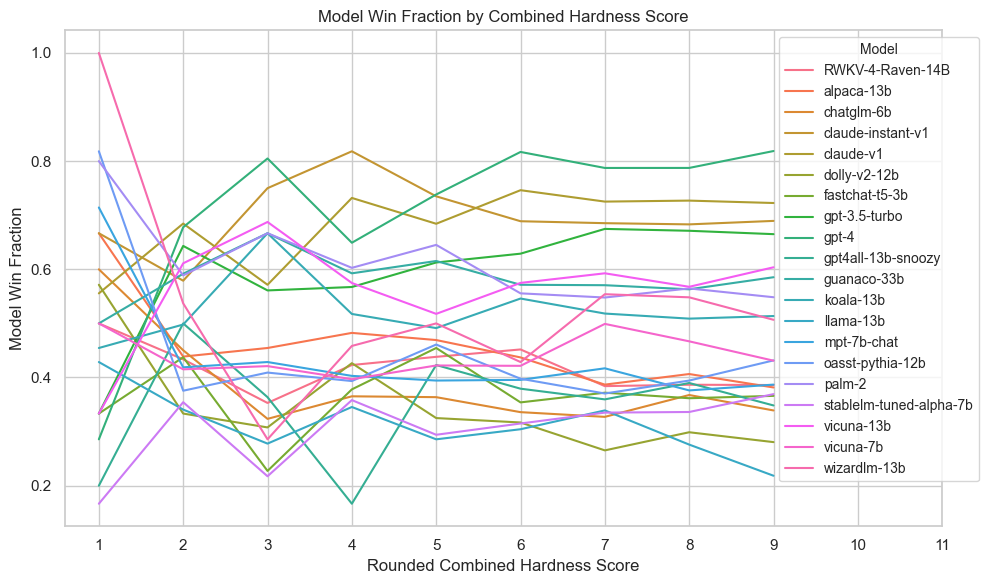

In [163]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=model_hardness_win_fracs, x='round_combined_hardness_score', y='win_frac', hue='model', ax=ax)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper right', fontsize='small', title_fontsize='small')
plt.xticks(np.arange(1, 12, 1))
plt.title('Model Win Fraction by Combined Hardness Score')
plt.ylabel('Model Win Fraction')
plt.xlabel('Rounded Combined Hardness Score')
plt.tight_layout()

In [164]:
merge_df.groupby(['round_combined_hardness_score', 'winning_model']).agg('size')
# merge_df.groupby(['round_combined_hardness_score', 'model_a']).agg('size') 
# + merge_df.groupby(['round_combined_hardness_score', 'model_b']).agg('size')

round_combined_hardness_score  winning_model          
1.0                            RWKV-4-Raven-14B             3
                               alpaca-13b                   4
                               chatglm-6b                   3
                               claude-instant-v1            2
                               claude-v1                    5
                                                         ... 
9.0                            palm-2                     136
                               stablelm-tuned-alpha-7b     89
                               vicuna-13b                 291
                               vicuna-7b                   97
                               wizardlm-13b                38
Length: 180, dtype: int64

In [165]:
merge_df.groupby(['round_combined_hardness_score'])[['model_a']].value_counts().reset_index(level=1)

,model_a,count
round_combined_hardness_score,,
1.0,vicuna-13b,7
1.0,gpt-4,6
1.0,koala-13b,6
1.0,claude-v1,5
1.0,dolly-v2-12b,4
...,...,...
9.0,dolly-v2-12b,105
9.0,llama-13b,86
9.0,gpt4all-13b-snoozy,48


In [166]:
merge_df[['model_a', 'model_b', 'winning_model', 'round_combined_hardness_score']]

,model_a,model_b,winning_model,round_combined_hardness_score
0,chatglm-6b,koala-13b,koala-13b,9.0
1,oasst-pythia-12b,alpaca-13b,alpaca-13b,8.0
2,koala-13b,oasst-pythia-12b,oasst-pythia-12b,3.0
3,vicuna-13b,oasst-pythia-12b,oasst-pythia-12b,8.0
4,vicuna-13b,koala-13b,vicuna-13b,2.0
...,...,...,...,...
25297,palm-2,chatglm-6b,palm-2,7.0
25298,alpaca-13b,claude-instant-v1,claude-instant-v1,2.0
25299,claude-instant-v1,guanaco-33b,claude-instant-v1,8.0
25300,guanaco-33b,koala-13b,guanaco-33b,8.0


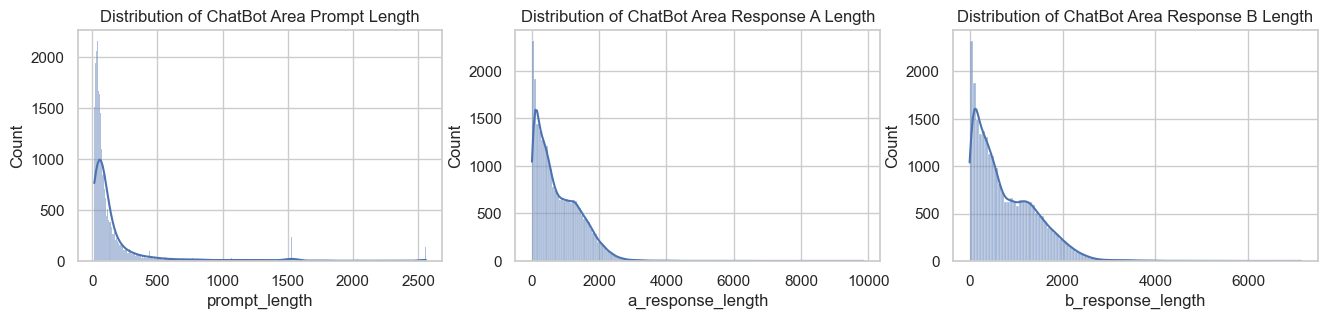

In [169]:
#Distribution of the prompt and response  (Histograms)
df["prompt"] = df["conversation_a"].str[0].str["content"]
df["prompt_length"] = df["prompt"].str.len()
df["response_a"] = df["conversation_a"].str[1].str["content"]
df["a_response_length"] = df["response_a"].str.len()
df["response_b"] = df["conversation_b"].str[1].str["content"]
df["b_response_length"] = df["response_b"].str.len()

fig, axes = plt.subplots(1, 3, figsize=(16, 3))  
sns.histplot(df["prompt_length"], kde=True, ax=axes[0])
axes[0].set_title("Distribution of ChatBot Area Prompt Length")

sns.histplot(df["a_response_length"], kde=True, ax=axes[1])
axes[1].set_title("Distribution of ChatBot Area Response A Length")

sns.histplot(df["b_response_length"], kde=True, ax=axes[2])
axes[2].set_title("Distribution of ChatBot Area Response B Length")

plt.show()

Median: 72.0


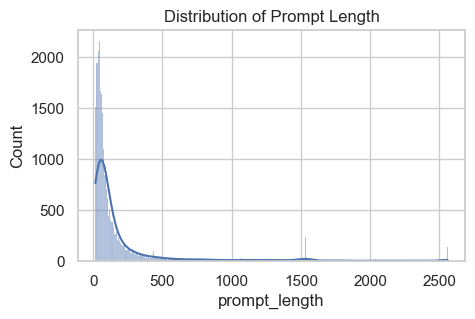

In [170]:
#combining both response series into a single series to plot length by whole dataset
plt.figure(figsize = (5,3))
sns.histplot(df["prompt_length"], kde=True)
plt.title("Distribution of Prompt Length")
print("Median:", df["prompt_length"].median())

(50564,)


Text(0.5, 0, 'response_length')

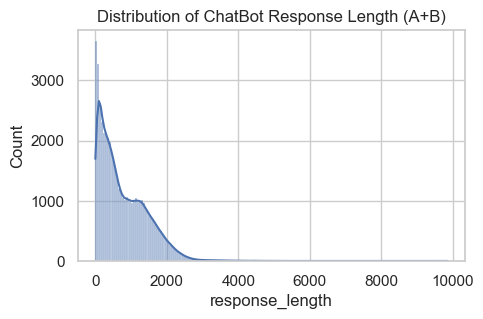

In [171]:
#combining both response series into a single series to plot length by whole dataset
plt.figure(figsize = (5,3))
combined_response_length = pd.concat([df["a_response_length"],df["b_response_length"]], ignore_index = True)
print(combined_response_length.shape)
sns.histplot(combined_response_length, kde=True)
plt.title("Distribution of ChatBot Response Length (A+B)")
plt.xlabel("response_length")

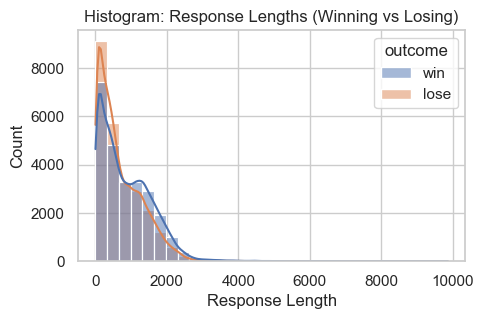

In [172]:
# Create a new DataFrame for 'win' and 'lose' response lengths
data_win_lose = pd.DataFrame({
    'response_length': df.apply(
        lambda row: row['a_response_length'] if row['winner'] == 'model_a' 
                    else row['b_response_length'], axis=1),
    'outcome': 'win'
})

data_lose = pd.DataFrame({
    'response_length': df.apply(
        lambda row: row['b_response_length'] if row['winner'] == 'model_a' 
                    else row['a_response_length'], axis=1),
    'outcome': 'lose'
})

# Combine both winning and losing responses into a single DataFrame
combined_data = pd.concat([data_win_lose, data_lose], ignore_index=True)

# Optional: Histogram for more clarity
plt.figure(figsize=(5, 3))
sns.histplot(data=combined_data, x='response_length', hue='outcome', kde=True, bins=30)
plt.title('Histogram: Response Lengths (Winning vs Losing)')
plt.xlabel('Response Length')
plt.ylabel('Count')
plt.show()


Number of points in each bin:
    length_bin  count
0            0   3348
1           50   3199
2          100   2555
3          150   2185
4          200   2039
..         ...    ...
76        3800      5
77        3850      4
78        3900     10
79        3950      4
80        4000      2

[81 rows x 2 columns]


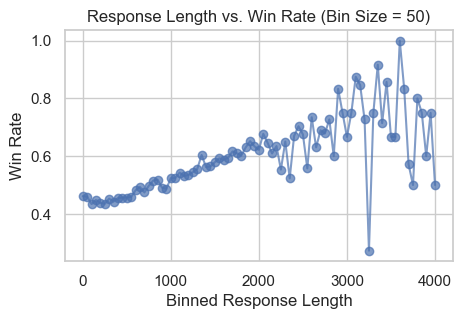

In [173]:
def plot_response_length_vs_win_rate(df, bin_size=100, max_length=4000):
    # Create a new DataFrame tracking each response's length and win status
    response_data = pd.DataFrame({
        'response_length': df.apply(
            lambda row: row['a_response_length'] if row['winner'] == 'model_a' 
                        else row['b_response_length'], axis=1),
        'won': 1
    })

    # Add losing responses to the data
    losing_data = pd.DataFrame({
        'response_length': df.apply(
            lambda row: row['b_response_length'] if row['winner'] == 'model_a' 
                        else row['a_response_length'], axis=1),
        'won': 0
    })

    # Combine both winning and losing responses
    combined_data = pd.concat([response_data, losing_data], ignore_index=True)

    # Create bins 
    combined_data['length_bin'] = (combined_data['response_length'] // bin_size) * bin_size

    # Calculate win rate and count of points for each bin
    bin_stats = combined_data.groupby('length_bin').agg(
        win_rate=('won', 'mean'),  # Mean gives the win rate
        count=('won', 'size')      # Size gives the number of points in each bin
    ).reset_index()

    # Filter out bins with response lengths greater than max_length
    bin_stats = bin_stats[bin_stats['length_bin'] <= max_length]

    
    print("Number of points in each bin:")
    print(bin_stats[['length_bin', 'count']])

    
    plt.figure(figsize=(5, 3))
    plt.plot(bin_stats['length_bin'], bin_stats['win_rate'], marker='o', alpha=0.7)
    plt.title(f'Response Length vs. Win Rate (Bin Size = {bin_size})')
    plt.xlabel('Binned Response Length')
    plt.ylabel('Win Rate')
    plt.grid(True)
    plt.show()

# Example Usage (Use your actual DataFrame)
plot_response_length_vs_win_rate(df, bin_size=50, max_length=4000)


Text(0.5, 0, 'Outcome')

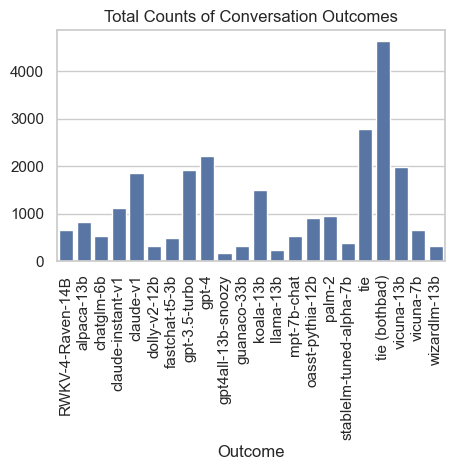

In [175]:
#Generating stats on win rate
plt.figure(figsize = (5,3))
df["winning_model"] = df.apply(
    lambda row: row["model_a"] if row["winner"] == "model_a" 
    else (row["model_b"] if row["winner"] == "model_b" 
          else row["winner"]),
    axis=1
)
outcome_stats = df.groupby(by="winning_model").size()
sns.barplot(outcome_stats)
plt.xticks(rotation=90)
plt.title("Total Counts of Conversation Outcomes")
plt.xlabel("Outcome")

In [176]:
#checking that there are no instances of models being the same per conversation
same_model = (df["model_a"] == df["model_b"])
print(same_model.value_counts())

False    25282
Name: count, dtype: int64


In [177]:
chatbot_distribution_a = df.groupby("model_a").size().reset_index()
chatbot_distribution_b = df.groupby("model_b").size().reset_index()

chatbot_distribution_a.merge(chatbot_distribution_b, left_on= "model_a", right_on="model_b")
chatbot_distribution = chatbot_distribution_a.rename(columns={"model_a": "model"})
chatbot_distribution

,model,0
0,RWKV-4-Raven-14B,1353
1,alpaca-13b,1619
2,chatglm-6b,1370
3,claude-instant-v1,1046
4,claude-v1,1562
5,dolly-v2-12b,1046
6,fastchat-t5-3b,1178
7,gpt-3.5-turbo,1779
8,gpt-4,1639
9,gpt4all-13b-snoozy,397


In [178]:
# Get all unique models from 'model_a' and 'model_b'
models = pd.concat([df["model_a"], df["model_b"]]).unique()

# Initialize a list to store the outcome statistics for each model
outcome_stats = []

# Iterate over each unique model to calculate rates
for model in models:
    # Calculate the number of wins, losses, tie-good, and tie-bad for the current model
    wins = ((df["winner"] == "model_a") & (df["model_a"] == model)).sum() + \
           ((df["winner"] == "model_b") & (df["model_b"] == model)).sum()
    
    losses = ((df["winner"] == "model_a") & (df["model_b"] == model)).sum() + \
             ((df["winner"] == "model_b") & (df["model_a"] == model)).sum()
    
    tie_good = ((df["winner"] == "tie") & 
                ((df["model_a"] == model) | (df["model_b"] == model))).sum()
    
    tie_bad = ((df["winner"] == "tie (bothbad)") & 
               ((df["model_a"] == model) | (df["model_b"] == model))).sum()

    # Calculate the total number of matches involving this model
    total_matches = ((df["model_a"] == model) | (df["model_b"] == model)).sum()

    # Avoid division by zero by checking if total_matches > 0
    if total_matches > 0:
        win_rate = wins / total_matches
        loss_rate = losses / total_matches
        tie_good_rate = tie_good / total_matches
        tie_bad_rate = tie_bad / total_matches
    else:
        win_rate = loss_rate = tie_good_rate = tie_bad_rate = 0

    # Append the results to the list
    outcome_stats.append([model, win_rate, loss_rate, tie_good_rate, tie_bad_rate])

# Create a DataFrame from the list of outcome statistics
outcome_rate = pd.DataFrame(outcome_stats, 
                            columns=["Model", "Win Rate", "Loss Rate", 
                                     "Tie-Good Rate", "Tie-Bad Rate"])

# Display the outcome_rate DataFrame
outcome_rate = outcome_rate.set_index("Model")
outcome_rate

,Win Rate,Loss Rate,Tie-Good Rate,Tie-Bad Rate
Model,,,,
chatglm-6b,0.198138,0.470764,0.085289,0.245810
oasst-pythia-12b,0.241015,0.452431,0.087738,0.218816
koala-13b,0.350212,0.333961,0.121291,0.194536
vicuna-13b,0.438472,0.265215,0.140826,0.155486
stablelm-tuned-alpha-7b,0.178538,0.507401,0.073080,0.240981
alpaca-13b,0.244855,0.454817,0.079332,0.220996
llama-13b,0.147116,0.560596,0.058976,0.233312
dolly-v2-12b,0.155609,0.537947,0.054893,0.251551
fastchat-t5-3b,0.197251,0.472110,0.084883,0.245756


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'gpt-4'),
  Text(1, 0, 'claude-v1'),
  Text(2, 0, 'claude-instant-v1'),
  Text(3, 0, 'gpt-3.5-turbo'),
  Text(4, 0, 'vicuna-13b'),
  Text(5, 0, 'guanaco-33b'),
  Text(6, 0, 'palm-2'),
  Text(7, 0, 'wizardlm-13b'),
  Text(8, 0, 'koala-13b'),
  Text(9, 0, 'vicuna-7b'),
  Text(10, 0, 'alpaca-13b'),
  Text(11, 0, 'oasst-pythia-12b'),
  Text(12, 0, 'mpt-7b-chat'),
  Text(13, 0, 'gpt4all-13b-snoozy'),
  Text(14, 0, 'RWKV-4-Raven-14B'),
  Text(15, 0, 'chatglm-6b'),
  Text(16, 0, 'fastchat-t5-3b'),
  Text(17, 0, 'stablelm-tuned-alpha-7b'),
  Text(18, 0, 'dolly-v2-12b'),
  Text(19, 0, 'llama-13b')])

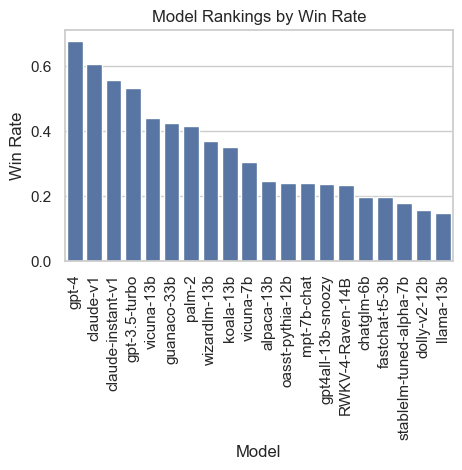

In [179]:
model_ranking = outcome_rate["Win Rate"].sort_values(ascending = False)
model_ranking
plt.figure(figsize = (5,3))
sns.barplot(data = model_ranking)
plt.title("Model Rankings by Win Rate")
plt.xticks(rotation = 90)